
# Table of contents
1. [Write/read networks](#pickle)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def nrml(a):    # Normalize in [0,1]
    return (a - a.min()) / (a.max() - a.min())


def nrml_(a):   # Normalize in [-1,1]
    return 2*(a - a.min()) / (a.max() - a.min()) -1


df = pd.read_csv("trade_matrix_clean.csv") 
# ahora se va a usar el data set en comun con gdp y pop
df=pd.read_csv('normalization/datasets_intersection/intersection_gdp_pop_tradeMatrix.csv')

In [3]:
df.head(int(15))

importer    exporter                                    Item  \
0   Afghanistan   Argentina                                   Maize   
1   Afghanistan   Argentina                                   Maize   
2   Afghanistan   Australia  Rice - total  (Rice milled equivalent)   
3   Afghanistan   Australia  Rice - total  (Rice milled equivalent)   
4   Afghanistan  Azerbaijan  Rice - total  (Rice milled equivalent)   
5   Afghanistan  Azerbaijan  Rice - total  (Rice milled equivalent)   
6   Afghanistan  Azerbaijan                                   Wheat   
7   Afghanistan  Azerbaijan                                   Wheat   
8   Afghanistan      Canada                                Soybeans   
9   Afghanistan      Canada                                Soybeans   
10  Afghanistan      Canada                                   Wheat   
11  Afghanistan      Canada                                   Wheat   
12  Afghanistan      Canada                                   Wheat   
13  Afghanistan      Canada                                   Wheat   
14  Afghanistan       China  Rice - total  (Rice milled equivalent)   

            Element  Year      Unit   Value  
0   Import Quantity  2017    tonnes   130.0  
1      Import Value  2017  1000 US$    68.0  
2   Import Quantity  2010    tonnes    32.0  
3      Import Value  2010  1000 US$    21.0  
4   Import Quantity  2014    tonnes    16.0  
5      Import Value  2014  1000 US$    19.0  
6   Import Quantity  2009    tonnes    88.0  
7      Import Value  2009  1000 US$    31.0  
8   Import Quantity  2015    tonnes   206.0  
9      Import Value  2015  1000 US$   124.0  
10  Import Quantity  2010    tonnes    80.0  
11  Import Quantity  2011    tonnes  2933.0  
12     Import Value  2010  1000 US$    31.0  
13     Import Value  2011  1000 US$   871.0  
14  Import Quantity  2011    tonnes  2586.0

In [4]:
df.exporter.unique().shape

(244,)

In [5]:
df.importer.unique().shape

(184,)

In [7]:
#  create a dictionary with global amount of trade
    # quantity = Total imports 
    # mean_val = Average price 

items = df.groupby('Item').groups.keys()
glob_dict = {}            
py = df.groupby('Year')  # py = Per Year 
for year, group in py:
    glob_dict[year] = {}
    for itm in items:
        glob_dict[year][itm] = {}
        glob_dict[year][itm]['quantity'] = group.loc[group['Item']==itm].loc[group['Element']=='Import Quantity']['Value'].sum()
        glob_dict[year][itm]['mean_val'] = group.loc[group['Item']==itm].loc[group['Element']=='Import Value']['Value'].mean()



norm_dict = {}    # create a new dictionary for normalizing values
for itm in items:
    norm_dict[itm] = {}
    for year in range(1986, 2018):
        norm_dict[itm][year] = {}
        norm_dict[itm][year]['qt'] = glob_dict[year][itm]['quantity']
        norm_dict[itm][year]['vl'] = glob_dict[year][itm]['mean_val']


for itm in items:  # add normalized values to global yearly dictionary 
    dfa = pd.DataFrame(norm_dict[itm]).transpose()
    dfa['nqt'] = nrml(dfa['qt'])
    dfa['nvl'] = nrml(dfa['vl'])
    for year in range(1986, 2018):
        glob_dict[year][itm]['qnt'] = dfa.loc[year]['nqt']
        glob_dict[year][itm]['val'] = dfa.loc[year]['nvl']


In [8]:
for year in range(1987, 2018):  #  Calculate differences of trade values on consecutive years 
    for itm in items:
        glob_dict[year][itm]['delta_pr'] = np.abs(glob_dict[year][itm]['val'] - glob_dict[year-1][itm]['val'])
        glob_dict[year][itm]['delta_qt'] = np.abs(glob_dict[year][itm]['qnt'] - glob_dict[year-1][itm]['qnt'])
"""ESTA AL REVEZ LO DE ARRIBA DEBE SER dr on val y qt con qnt!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! """

        
norm_dict2 = {}    # create a dictionary for normalizing delta values
for itm in items:
    norm_dict2[itm] = {}
    for year in range(1987, 2018):
        norm_dict2[itm][year] = {}
        norm_dict2[itm][year]['delta_pr'] = glob_dict[year][itm]['delta_pr']
        norm_dict2[itm][year]['delta_qt'] = glob_dict[year][itm]['delta_qt']


for itm in items:  # add normalized delta values to global yearly dictionary 
    dfa = pd.DataFrame(norm_dict2[itm]).transpose()
    dfa['delta_pr_n'] = nrml(dfa['delta_pr'])
    dfa['delta_qt_n'] = nrml(dfa['delta_qt'])
    for year in range(1987, 2018):
        glob_dict[year][itm]['pertb_pr'] = dfa.loc[year]['delta_pr_n']
        glob_dict[year][itm]['pertb_qt'] = dfa.loc[year]['delta_qt_n']
        


In [9]:
for year in range(1987, 2018):  # take yearly mean of perturbation over Item list ...
    glob_dict[year]['PERTB_pr'] = pd.DataFrame(glob_dict[year]).transpose()['pertb_pr'].mean()
    glob_dict[year]['PERTB_qt'] = pd.DataFrame(glob_dict[year]).transpose()['pertb_qt'].mean()

DF = pd.DataFrame(glob_dict).transpose()
DF['perturb_pr'] = nrml(DF['PERTB_pr'])  # ... and Normalize them 
DF['perturb_qt'] = nrml(DF['PERTB_qt'])
for year in range(1987, 2018):             # Add normalized perturbations values to global dictionary 
    glob_dict[year]['pertN_pr'] = DF.loc[year]['perturb_pr']
    glob_dict[year]['pertN_qt'] = DF.loc[year]['perturb_qt']

In [10]:
dict_perts = {}    #   Create dictionary and DataFrame for perturbations 
for year in range(1987, 2018):
    dict_perts[year] = {}
    for x in ['pertN_pr','pertN_qt']:
        dict_perts[year][x] = glob_dict[year][x]
    for itm in items:
        for y in ['pertb_pr', 'pertb_qt']:
            dict_perts[year][itm+y[-3:]] = glob_dict[year][itm][y]
        

dfperts = pd.DataFrame(dict_perts).transpose()    
dfperts

pertN_pr  pertN_qt  Barley_pr  Barley_qt  Beans, dry_pr  Beans, dry_qt  \
1987  0.265091  0.249999   0.243246   0.099105       1.000000       1.000000   
1988  0.448076  0.152355   0.438655   0.449639       0.394244       0.154313   
1989  0.530722  0.428417   0.378938   0.013743       0.000080       0.302942   
1990  0.844045  0.610407   0.788551   0.848780       0.998428       0.575440   
1991  0.361251  0.156180   0.000000   0.283130       0.868810       0.015573   
1992  0.262029  0.098463   0.387664   0.112184       0.325925       0.121093   
1993  0.269684  0.390933   0.191738   0.321511       0.525365       0.421050   
1994  0.445251  0.673467   0.211897   0.381382       0.627882       0.579368   
1995  0.165367  0.084954   0.117418   0.029566       0.137972       0.111456   
1996  0.314725  0.072923   0.416572   0.155422       0.369942       0.171407   
1997  0.393315  0.228194   0.524502   0.000000       0.084280       0.168354   
1998  0.397152  0.506250   0.521918   0.494013       0.081539       0.193247   
1999  0.214413  0.004463   0.195611   0.075887       0.322880       0.015725   
2000  0.177612  0.382201   0.329393   1.000000       0.558658       0.044182   
2001  0.106630  0.278327   0.254961   0.224375       0.031024       0.432075   
2002  0.000000  0.343214   0.081169   0.062321       0.095711       0.216725   
2003  0.070393  0.289520   0.087348   0.421957       0.143563       0.340261   
2004  0.131626  0.194236   0.470487   0.416812       0.134875       0.393073   
2005  0.052141  0.248356   0.136283   0.378287       0.209581       0.084883   
2006  0.100525  0.000000   0.004556   0.071181       0.645484       0.353009   
2007  0.839902  0.524722   1.000000   0.135719       0.276973       0.304336   
2008  1.000000  0.486495   0.000064   0.801025       0.957171       0.172760   
2009  0.939945  0.652622   0.460248   0.785825       0.356149       0.439742   
2010  0.237347  0.439460   0.121921   0.420942       0.424373       0.766753   
2011  0.882254  0.353827   0.904939   0.198850       0.274555       0.349468   
2012  0.271776  0.137174   0.085693   0.325451       0.252499       0.267316   
2013  0.143824  0.198671   0.423201   0.528492       0.172143       0.000000   
2014  0.378648  1.000000   0.696038   0.706070       0.000000       0.017034   
2015  0.415074  0.615469   0.010670   0.747721       0.328379       0.061011   
2016  0.434351  0.605627   0.932186   0.361321       0.083856       0.458183   
2017  0.528012  0.969982   0.647536   0.940134       0.477605       0.325436   

      Chick peas_pr  Chick peas_qt  Groundnuts, shelled_pr  \
1987       0.610299       0.223070                0.223848   
1988       0.514593       0.028526                0.024244   
1989       0.066536       0.111834                0.000000   
1990       0.220716       0.081583                0.446162   
1991       0.146997       0.003039                0.330462   
1992       0.024828       0.048084                0.634526   
1993       0.019181       0.104728                0.130767   
1994       0.335914       0.254540                0.061164   
1995       0.037792       0.000000                0.133901   
1996       0.256510       0.228950                0.134720   
1997       0.088646       0.188570                0.070016   
1998       0.263151       0.238733                0.425143   
1999       0.199555       0.142867                0.264407   
2000       0.191442       0.254750                0.041100   
2001       0.347422       0.532288                0.213498   
2002       0.329879       0.267847                0.112801   
2003       0.060453       0.017159                0.161800   
2004       0.000000       0.174755                0.250594   
2005       0.218008       0.226051                0.025577   
2006       0.032675       0.134272                0.065318   
2007       0.158309       0.189280                0.736932   
2008       0.018215       0.024194                0.917654   
2009       0.038442

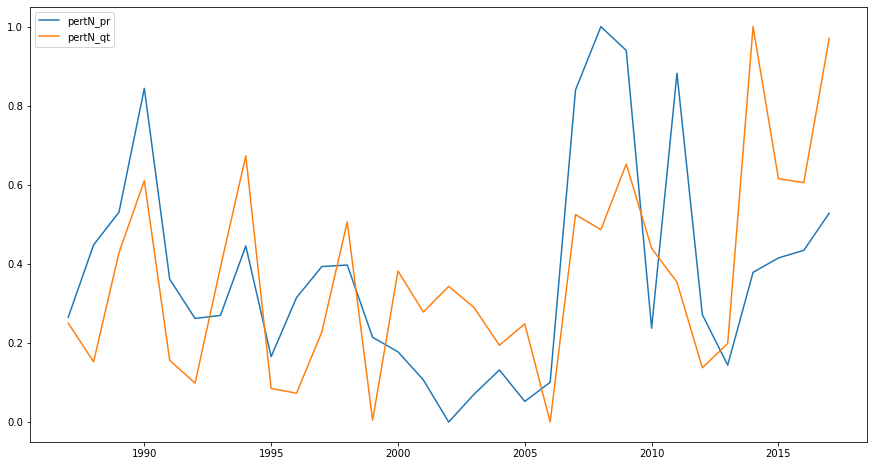

In [11]:
dfperts.plot(y=[x for x in dfperts.columns if x[:4]=='pert'], figsize=(15, 8))

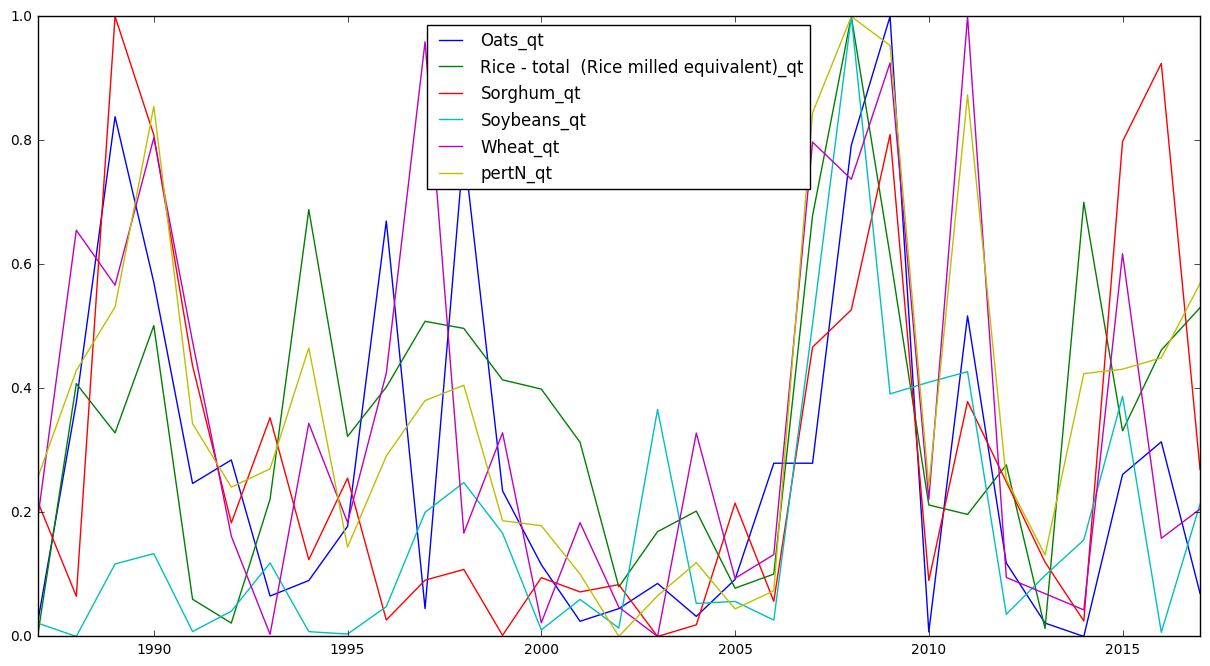

In [305]:
dfperts.plot(y=[x for x in dfperts.columns if x[-2:]=='qt'][6:], figsize=(15, 8))


In [12]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in glob_dict.items() for innerKey, values in innerDict.items()}
gdf = pd.DataFrame(reform).transpose();
gdf

quantity      mean_val       qnt       val  \
1986 Barley               1.547741e+07   7507.169421  0.216713  0.621852   
     Beans, dry           1.970451e+06   1208.821053  0.360204  0.713006   
     Chick peas           1.612800e+05    581.842105  0.000000  0.205972   
     Groundnuts, shelled  7.260230e+05   1538.791139  0.045673  0.274165   
     Maize                5.106377e+07  12134.436170  0.036029  0.424520   
...                                ...           ...       ...       ...   
2017 Wheat                1.794171e+08  23982.486159  1.000000  0.469980   
     PERTB_pr             3.746757e-01      0.374676  0.374676  0.374676   
     PERTB_qt             5.269618e-01      0.526962  0.526962  0.526962   
     pertN_pr             5.280116e-01      0.528012  0.528012  0.528012   
     pertN_qt             9.699824e-01      0.969982  0.969982  0.969982   

                          delta_pr  delta_qt  pertb_pr  pertb_qt  
1986 Barley                    NaN       NaN       NaN       NaN  
     Beans, dry                NaN       NaN       NaN       NaN  
     Chick peas                NaN       NaN       NaN       NaN  
     Groundnuts, shelled       NaN       NaN       NaN       NaN  
     Maize                     NaN       NaN       NaN       NaN  
...                            ...       ...       ...       ...  
2017 Wheat                0.080387  0.035782  0.205511  0.127051  
     PERTB_pr             0.374676  0.374676  0.374676  0.374676  
     PERTB_qt             0.526962  0.526962  0.526962  0.526962  
     pertN_pr             0.528012  0.528012  0.528012  0.528012  
     pertN_qt             0.969982  0.969982  0.969982  0.969982  

[476 rows x 8 columns]

In [21]:
df.head(int(10))

importer    exporter                                    Item  \
0  Afghanistan   Argentina                                   Maize   
1  Afghanistan   Argentina                                   Maize   
2  Afghanistan   Australia  Rice - total  (Rice milled equivalent)   
3  Afghanistan   Australia  Rice - total  (Rice milled equivalent)   
4  Afghanistan  Azerbaijan  Rice - total  (Rice milled equivalent)   
5  Afghanistan  Azerbaijan  Rice - total  (Rice milled equivalent)   
6  Afghanistan  Azerbaijan                                   Wheat   
7  Afghanistan  Azerbaijan                                   Wheat   
8  Afghanistan      Canada                                Soybeans   
9  Afghanistan      Canada                                Soybeans   

           Element  Year      Unit  Value  
0  Import Quantity  2017    tonnes  130.0  
1     Import Value  2017  1000 US$   68.0  
2  Import Quantity  2010    tonnes   32.0  
3     Import Value  2010  1000 US$   21.0  
4  Import Quantity  2014    tonnes   16.0  
5     Import Value  2014  1000 US$   19.0  
6  Import Quantity  2009    tonnes   88.0  
7     Import Value  2009  1000 US$   31.0  
8  Import Quantity  2015    tonnes  206.0  
9     Import Value  2015  1000 US$  124.0

In [23]:
#  create a dictionary with amount of trade per country
    # quantity = Total imports 
    # mean_val = Average price     
    
items = df.groupby('Item').groups.keys()
dict_country = {}            
pc = df.groupby('Year')  # pc = Per Country 

for name, group in df.groupby('importer'):
    dict_country[name] = {}
    
for name, group in df.groupby('exporter'):
    if name not in dict_country.keys():
        dict_country[name] = {}

year = int(1986)
for G in lg:
    for x in G.nodes():
        dict_country[x][year] = {}
        for y in G.out_edges(x):        
            for key, val in G[y[0]][y[1]].items():
                for k, v in val.items():
                    dict_country[x][year]['exp_'+key+'_'+k] = v
        for y in G.in_edges(x):
            for key, val in G[y[0]][y[1]].items():
                for k, v in val.items():
                    dict_country[x][year]['imp_'+key+'_'+k] = v
    year += 1
            
        

In [24]:
for key, val in dict_country.items():
    xxx = pd.DataFrame(val).transpose()
    for col in xxx.columns:
        xxx[col] = nrml(xxx[col])
        xxx['dlt_'+col] = xxx[col] - xxx[col].shift(1)
        xxx['dlt_'+col] = nrml_(xxx['dlt_'+col])
    for year in range(1987, 2018):
        try:
            dict_country[key][year]['dlt_in_pr'] = xxx.drop([xc for xc in xxx.columns if 'dlt_imp_' != xc[:8] or '_value' not in xc ], axis=1).transpose()[year].mean()
            dict_country[key][year]['dlt_in_vl'] = xxx.drop([xc for xc in xxx.columns if 'dlt_imp_' != xc[:8] or '_weight' not in xc ], axis=1).transpose()[year].mean()
            dict_country[key][year]['dlt_ex_pr'] = xxx.drop([xc for xc in xxx.columns if 'dlt_exp_' != xc[:8] or '_value' not in xc ], axis=1).transpose()[year].mean()
            dict_country[key][year]['dlt_ex_vl'] = xxx.drop([xc for xc in xxx.columns if 'dlt_exp_' != xc[:8] or '_weight' not in xc ], axis=1).transpose()[year].mean()
        except: 
            print (key, year)

Afghanistan 1988
Armenia 1987
Armenia 1988
Armenia 1989
Armenia 1990
Armenia 1991
Armenia 1992
Armenia 1993
Armenia 1994
Armenia 1995
Armenia 1996
Aruba 1987
Aruba 1988
Aruba 1989
Aruba 1992
Aruba 2013
Azerbaijan 1987
Azerbaijan 1988
Azerbaijan 1989
Azerbaijan 1990
Azerbaijan 1991
Azerbaijan 1993
Azerbaijan 1994
Azerbaijan 1996
Bahamas, The 1987
Bahamas, The 1988
Bahamas, The 1989
Bahamas, The 1990
Bahamas, The 1991
Bahamas, The 1993
Bahamas, The 1996
Bahrain 1987
Bahrain 1988
Bahrain 1991
Bahrain 1992
Bahrain 1994
Bangladesh 1987
Bangladesh 1988
Bangladesh 1990
Belarus 1987
Belarus 1988
Belarus 1989
Belarus 1990
Belarus 1991
Belgium 1987
Belgium 1988
Belgium 1989
Belgium 1990
Belgium 1991
Belgium 1992
Belgium 1993
Belgium 1994
Belgium 1995
Belgium 1996
Belgium 1997
Belgium 1998
Belgium 1999
Belgium-Luxembourg 2000
Belgium-Luxembourg 2001
Belgium-Luxembourg 2003
Belgium-Luxembourg 2004
Belgium-Luxembourg 2005
Belgium-Luxembourg 2006
Belgium-Luxembourg 2007
Belgium-Luxembourg 2008
Belgi

Netherlands Antilles (former) 1988
Netherlands Antilles (former) 1990
Netherlands Antilles (former) 2014
Netherlands Antilles (former) 2015
Netherlands Antilles (former) 2016
New Caledonia 1987
New Caledonia 1988
New Caledonia 1989
New Caledonia 1990
New Caledonia 1991
New Caledonia 1993
New Caledonia 1994
New Caledonia 1996
New Caledonia 1997
New Caledonia 1998
New Caledonia 1999
Niger 1988
Niger 1989
North Macedonia 1987
North Macedonia 1988
North Macedonia 1989
North Macedonia 1990
North Macedonia 1991
Papua New Guinea 1991
Papua New Guinea 1992
Papua New Guinea 1993
Papua New Guinea 1994
Papua New Guinea 1995
Papua New Guinea 1997
Papua New Guinea 1998
Qatar 1987
Qatar 1988
Qatar 1990
Russian Federation 1987
Russian Federation 1988
Russian Federation 1989
Russian Federation 1990
Russian Federation 1991
Rwanda 1987
Rwanda 1988
Rwanda 1989
Rwanda 1990
Rwanda 1991
Rwanda 1992
Rwanda 1994
Rwanda 2004
Réunion 1997
Réunion 1999
Réunion 2000
Réunion 2001
Réunion 2002
Réunion 2003
Réunion 

Cocos (Keeling) Islands 2002
Cocos (Keeling) Islands 2003
Cocos (Keeling) Islands 2004
Cocos (Keeling) Islands 2005
Cocos (Keeling) Islands 2006
Cocos (Keeling) Islands 2007
Cocos (Keeling) Islands 2008
Cocos (Keeling) Islands 2009
Cocos (Keeling) Islands 2010
Cocos (Keeling) Islands 2011
Cocos (Keeling) Islands 2012
Cocos (Keeling) Islands 2013
Cocos (Keeling) Islands 2014
Cocos (Keeling) Islands 2016
Cocos (Keeling) Islands 2017
Czechoslovakia 1993
Czechoslovakia 1996
Czechoslovakia 1997
Czechoslovakia 1998
Czechoslovakia 2000
Czechoslovakia 2001
Czechoslovakia 2002
Czechoslovakia 2003
Czechoslovakia 2004
Czechoslovakia 2005
Czechoslovakia 2006
Czechoslovakia 2007
Czechoslovakia 2008
Czechoslovakia 2009
Czechoslovakia 2010
Czechoslovakia 2011
Czechoslovakia 2012
Czechoslovakia 2013
Czechoslovakia 2014
Czechoslovakia 2015
Czechoslovakia 2016
Czechoslovakia 2017
Dominican Republic 1987
Dominican Republic 1988
Equatorial Guinea 1987
Equatorial Guinea 1988
Equatorial Guinea 1989
Equatori

Pitcairn Islands 2009
Pitcairn Islands 2010
Pitcairn Islands 2011
Pitcairn Islands 2012
Pitcairn Islands 2013
Pitcairn Islands 2014
Pitcairn Islands 2015
Pitcairn Islands 2016
Pitcairn Islands 2017
Puerto Rico 1987
Puerto Rico 2000
Puerto Rico 2001
Puerto Rico 2002
Puerto Rico 2003
Puerto Rico 2004
Puerto Rico 2005
Puerto Rico 2006
Puerto Rico 2007
Puerto Rico 2008
Puerto Rico 2009
Puerto Rico 2010
Puerto Rico 2011
Puerto Rico 2012
Puerto Rico 2013
Puerto Rico 2014
Puerto Rico 2015
Puerto Rico 2016
Puerto Rico 2017
Saint Helena, Ascension and Tristan da Cunha 1987
Saint Helena, Ascension and Tristan da Cunha 1988
Saint Helena, Ascension and Tristan da Cunha 1990
Saint Helena, Ascension and Tristan da Cunha 1991
Saint Helena, Ascension and Tristan da Cunha 1992
Saint Helena, Ascension and Tristan da Cunha 1993
Saint Helena, Ascension and Tristan da Cunha 1994
Saint Helena, Ascension and Tristan da Cunha 1995
Saint Helena, Ascension and Tristan da Cunha 1997
Saint Helena, Ascension and T

In [25]:
dictotal = {} 
i = 0
j = 0
lp = []
for country in dict_country.keys():
    dictotal[country] = {}
    for year in dict_perts.keys():
        dictotal[country][year] = {}
        try:
            dictotal[country][year]['af_in_pr'] = -1*dict_country[country][year]['dlt_in_pr'] * dict_perts[year]['pertN_pr']
            dictotal[country][year]['af_in_vl'] = -1*dict_country[country][year]['dlt_in_vl'] * dict_perts[year]['pertN_qt']
            dictotal[country][year]['af_ex_pr'] = dict_country[country][year]['dlt_ex_pr'] * dict_perts[year]['pertN_pr']
            dictotal[country][year]['af_ex_vl'] = dict_country[country][year]['dlt_ex_vl'] * dict_perts[year]['pertN_qt']
            dictotal[country][year]['af_in_pr2'] = -1*dict_country[country][year]['dlt_in_pr'] * (dict_perts[year]['pertN_pr'] + dict_perts[year]['pertN_qt'])/2
            dictotal[country][year]['af_in_vl2'] = -1*dict_country[country][year]['dlt_in_vl'] * (dict_perts[year]['pertN_pr'] + dict_perts[year]['pertN_qt'])/2
            dictotal[country][year]['af_ex_pr2'] = dict_country[country][year]['dlt_ex_pr'] * (dict_perts[year]['pertN_pr'] + dict_perts[year]['pertN_qt'])/2
            dictotal[country][year]['af_ex_vl2'] = dict_country[country][year]['dlt_ex_vl'] * (dict_perts[year]['pertN_pr'] + dict_perts[year]['pertN_qt'])/2
        except:
            j += 1
            lp += [country]
        i += 1
print('total loops = ',i, 'total exceptions = ',j)

total loops =  7564 total exceptions =  1925


In [26]:
"""
Compare with: 
 - GDP
 - Total Exports - Total Imports. 
 - resource export - import
 - distance imported, distance exported. 
 - population size  
"""



tk = {}
for key, val in dictotal.items():
    tk[key] = {}
    ddff = pd.DataFrame(val).transpose()
    for col in ddff.columns:
        tk[key][col] = ddff[col].mean()


In [27]:
pd.DataFrame(tk).transpose()

af_in_pr  af_in_vl  af_ex_pr  af_ex_vl  af_in_pr2  \
Afghanistan               -0.109824 -0.019619  0.046899  0.016851  -0.067991   
Albania                   -0.010263  0.014441  0.001631 -0.000209  -0.009149   
Algeria                    0.018589  0.029775 -0.035675 -0.039405   0.017132   
Antigua and Barbuda        0.027695  0.006861 -0.015406 -0.004845   0.031859   
Argentina                  0.022036  0.014026  0.006932  0.001993   0.021439   
...                             ...       ...       ...       ...        ...   
Uzbekistan                      NaN       NaN  0.007528  0.009174        NaN   
Vietnam                         NaN       NaN -0.046759 -0.062166        NaN   
Virgin Islands (U.S.)           NaN       NaN       NaN       NaN        NaN   
Wallis and Futuna Islands       NaN       NaN       NaN       NaN        NaN   
Western Sahara                  NaN       NaN       NaN       NaN        NaN   

                           af_in_vl2  af_ex_pr2  af_ex_vl2  
Afghanistan                -0.059789   0.041051   0.027199  
Albania                     0.015782   0.021173  -0.022208  
Algeria                     0.030586  -0.028891  -0.049916  
Antigua and Barbuda         0.009436  -0.015411  -0.003907  
Argentina                   0.014498   0.001457   0.004153  
...                              ...        ...        ...  
Uzbekistan                       NaN   0.003445   0.008947  
Vietnam                          NaN  -0.043392  -0.062532  
Virgin Islands (U.S.)            NaN        NaN        NaN  
Wallis and Futuna Islands        NaN        NaN        NaN  
Western Sahara                   NaN        NaN        NaN  

[244 rows x 8 columns]

In [28]:
pd.DataFrame(tk).transpose().head(int(50))

af_in_pr  af_in_vl  af_ex_pr  af_ex_vl  \
Afghanistan                      -0.109824 -0.019619  0.046899  0.016851   
Albania                          -0.010263  0.014441  0.001631 -0.000209   
Algeria                           0.018589  0.029775 -0.035675 -0.039405   
Antigua and Barbuda               0.027695  0.006861 -0.015406 -0.004845   
Argentina                         0.022036  0.014026  0.006932  0.001993   
Armenia                           0.011216  0.007787  0.048272  0.086747   
Aruba                             0.031395  0.030479  0.049188  0.070061   
Australia                        -0.023050 -0.034217 -0.005646  0.012117   
Austria                          -0.024268 -0.039414  0.002932 -0.004885   
Azerbaijan                        0.001571  0.016129 -0.016870 -0.054347   
Bahamas, The                     -0.054326 -0.064087  0.069767  0.154605   
Bahrain                          -0.025571 -0.021651  0.016686 -0.003395   
Bangladesh                        0.080649  0.033256  0.031808  0.063851   
Barbados                          0.007293 -0.021420  0.064719  0.044033   
Belarus                           0.058446  0.054327 -0.020692 -0.042347   
Belgium                           0.003820  0.022933 -0.017829  0.012620   
Belgium-Luxembourg                0.011055 -0.002826  0.000976 -0.015111   
Belize                           -0.004833 -0.029628  0.038297  0.038331   
Benin                            -0.031723 -0.018747  0.021579 -0.002005   
Bermuda                           0.011830 -0.047712  0.075806  0.103513   
Bhutan                            0.025788 -0.066127 -0.002886  0.022729   
Bolivia                           0.009454 -0.003720  0.051775  0.074656   
Bosnia and Herzegovina           -0.011071  0.001506 -0.010920 -0.001711   
Botswana                          0.005895  0.005239  0.029392 -0.044704   
Brazil                           -0.035886 -0.045329 -0.029714 -0.022731   
Brunei Darussalam                 0.049375  0.069369  0.140096  0.168335   
Bulgaria                          0.055412  0.082714 -0.007452 -0.014964   
Burkina Faso                     -0.010194  0.016897 -0.081617  0.026358   
Burundi                          -0.025324  0.003445  0.054909  0.001492   
Cabo Verde                       -0.061540 -0.069116  0.001793  0.117321   
Cambodia                          0.051176  0.061406  0.072126  0.102250   
Cameroon                         -0.030015 -0.016571 -0.007157 -0.007860   
Canada                            0.005158  0.006128  0.006724  0.005987   
Central African Republic         -0.002970 -0.038991  0.212046  0.075045   
Chile                            -0.053322 -0.059740  0.016245  0.022086   
China                             0.055626  0.043606  0.018349  0.028609   
China, Hong Kong SAR             -0.019877 -0.012881  0.010984 -0.005399   
China, Macao SAR                  0.014141  0.020376 -0.053084 -0.014385   
China, Taiwan Province of        -0.035841 -0.028571  0.040942  0.050475   
Colombia                          0.023283  0.015922 -0.014285  0.014320   
Comoros                           0.005267  0.059281       NaN       NaN   
Congo, Dem. Rep.                 -0.029246 -0.042048 -0.002359  0.097870   
Cook Islands                     -0.029691  0.147915       NaN       NaN   
Costa Rica                       -0.078396 -0.081478 -0.007759 -0.015813   
Cote d'Ivoire                    -0.003777 -0.008902  0.042368  0.015833   
Croatia                           0.005054  0.028830  0.036731  0.073335   
Cuba                              0.065929  0.057354  0.041393 -0.094886   
Cyprus                           -0.000077 -0.025523  0.005603  0.020138   
Czech Republic                   -0.024193 -0.022801  0.010349  0.007512   
Democratic Republic of the Congo  0.124193 -0.063607  0.009915  0.023766   

                                  af_in_pr2  af_in_vl2  af_ex_pr2  af_ex_vl2  
Afghanistan                       -0.067991  -0.059789   0.041051   0.027199  

In [31]:
# afs.to_csv('normalization/datasets_intersection/af_food_trade_mean.csv')

In [30]:
afs = pd.DataFrame(tk).transpose()
for col in afs.columns:
    print(afs.sort_values(col).head(int(7))[col])

Ethiopia PDR      -0.153534
Slovak Republic   -0.120337
Afghanistan       -0.109824
Réunion           -0.108645
Grenada           -0.090743
Costa Rica        -0.078396
Faroe Islands     -0.066104
Name: af_in_pr, dtype: float64
Ethiopia PDR            -0.141848
Slovak Republic         -0.135106
Sao Tome and Principe   -0.131973
Réunion                 -0.129947
Yugoslav SFR            -0.097837
Costa Rica              -0.081478
Montserrat              -0.079542
Name: af_in_vl, dtype: float64
Cayman Islands   -0.367506
Mauritius        -0.141115
Monaco           -0.139942
Guinea-Bissau    -0.128800
Lesotho          -0.116307
Gambia, The      -0.110862
Jordan           -0.103870
Name: af_ex_pr, dtype: float64
Vanuatu                          -0.400665
Monaco                           -0.294257
Tokelau                          -0.210119
Sierra Leone                     -0.208357
Cayman Islands                   -0.199659
British Indian Ocean Territory   -0.146235
Equatorial Guinea         

In [33]:
afs = pd.DataFrame(tk).transpose()
for col in afs.columns:
    print(afs.sort_values(col, ascending=False).head(int(10))[col])

Iran (Islamic Republic of)    0.205572
Vanuatu                       0.189099
Tuvalu                        0.178664
Cuba                          0.110605
Guinea                        0.104829
Sierra Leone                  0.104813
Maldives                      0.085833
Kiribati                      0.084381
Gambia                        0.072647
Syrian Arab Republic          0.071358
Name: af_in_pr, dtype: float64
Vanuatu                             0.194388
Kiribati                            0.149876
Democratic Republic of the Congo    0.101544
Gambia                              0.098531
Libya                               0.096571
Iran (Islamic Republic of)          0.091318
Saint Lucia                         0.083056
Maldives                            0.079067
Cook Islands                        0.078640
Madagascar                          0.076982
Name: af_in_vl, dtype: float64
Vanuatu                        0.396704
Saint Kitts and Nevis          0.348616
Palestine         

In [32]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in dictotal.items() for innerKey, values in innerDict.items()}
a = pd.DataFrame(reform).transpose()
a

af_in_pr  af_in_vl  af_ex_pr  af_ex_vl  af_in_pr2  \
Afghanistan    1987       NaN       NaN  0.063262  0.249999        NaN   
               1988       NaN       NaN       NaN       NaN        NaN   
               1989       NaN       NaN       NaN       NaN        NaN   
               1990       NaN       NaN  0.144158  0.143266        NaN   
               1991       NaN       NaN  0.084314  0.048569        NaN   
...                       ...       ...       ...       ...        ...   
Western Sahara 2013       NaN       NaN       NaN       NaN        NaN   
               2014       NaN       NaN       NaN       NaN        NaN   
               2015       NaN       NaN       NaN       NaN        NaN   
               2016       NaN       NaN       NaN       NaN        NaN   
               2017       NaN       NaN       NaN       NaN        NaN   

                     af_in_vl2  af_ex_pr2  af_ex_vl2  
Afghanistan    1987        NaN   0.061462   0.257545  
               1988        NaN        NaN        NaN  
               1989        NaN        NaN        NaN  
               1990        NaN   0.124206   0.170685  
               1991        NaN   0.060383   0.080456  
...                        ...        ...        ...  
Western Sahara 2013        NaN        NaN        NaN  
               2014        NaN        NaN        NaN  
               2015        NaN        NaN        NaN  
               2016        NaN        NaN        NaN  
               2017        NaN        NaN        NaN  

[7564 rows x 8 columns]

In [76]:
# a.to_csv('normalization/datasets_intersection/af_PER_country_year.csv')

In [440]:
 <a name="matching_countries"></a>xxx = pd.DataFrame(dict_country['Canada']).transpose()
for col in xxx.columns:
    xxx[col] = nrml(xxx[col])
    xxx['dlt_'+col] = xxx[col] - xxx[col].shift(1)
    xxx['dlt_'+col] = nrml_(xxx['dlt_'+col])

In [437]:
for col in xxx.columns:
    xxx['dlt_'+col] = xxx[col] - xxx[col].shift(1)
    xxx['dlt_'+col] = nrml_(xxx['dlt_'+col])

In [459]:
xxx.drop([xc for xc in xxx.columns if 'dlt_imp_' != xc[:8]  ], axis=1).transpose()[1996]

dlt_imp_Barley_value                                    -0.920904
dlt_imp_Barley_weight                                   -0.893836
dlt_imp_Beans, dry_value                                 1.000000
dlt_imp_Beans, dry_weight                                1.000000
dlt_imp_Chick peas_value                                 0.303754
dlt_imp_Chick peas_weight                                0.408712
dlt_imp_Groundnuts, shelled_value                        0.082087
dlt_imp_Groundnuts, shelled_weight                       0.110311
dlt_imp_Maize_value                                      0.101139
dlt_imp_Maize_weight                                     0.189687
dlt_imp_Millet_value                                     0.388235
dlt_imp_Millet_weight                                    0.056604
dlt_imp_Oats_value                                       0.192090
dlt_imp_Oats_weight                                      0.154224
dlt_imp_Rice - total  (Rice milled equivalent)_value    -0.153509
dlt_imp_Ri

In [415]:
for country, val in dict_country.iteritems():
    dfpc = pd.DataFrame(val)
    
dict_country

{'Afghanistan': {2017: {'exp_Beans, dry_value': 70.0,
   'exp_Beans, dry_weight': 72.0,
   'exp_Chick peas_value': 2.0,
   'exp_Chick peas_weight': 1.0,
   'exp_Maize_value': 0.0,
   'exp_Maize_weight': 0.0,
   'exp_Soybeans_value': 0.0,
   'exp_Soybeans_weight': 0.0,
   'exp_Wheat_value': 0.0,
   'exp_Wheat_weight': 0.0,
   'imp_Barley_value': 2367.0,
   'imp_Barley_weight': 15387.0,
   'imp_Beans, dry_value': 9.0,
   'imp_Beans, dry_weight': 5.0,
   'imp_Chick peas_value': 394.0,
   'imp_Chick peas_weight': 435.0,
   'imp_Groundnuts, shelled_value': 564.0,
   'imp_Groundnuts, shelled_weight': 518.0,
   'imp_Maize_value': 15.0,
   'imp_Maize_weight': 135.0,
   'imp_Millet_value': 582.0,
   'imp_Millet_weight': 410.0,
   'imp_Rice - total  (Rice milled equivalent)_value': 1466.0,
   'imp_Rice - total  (Rice milled equivalent)_weight': 4576.0,
   'imp_Sorghum_value': 1.0,
   'imp_Sorghum_weight': 0.0,
   'imp_Soybeans_value': 22.0,
   'imp_Soybeans_weight': 40.0,
   'imp_Wheat_value': 5

In [416]:
len(lg)

32

In [373]:
for x in G.nodes_iter():
    for y in G.out_edges_iter(x):
        print G[y[0]][y[1]]
    quit
        

{'Maize': {'value': 148003.0, 'weight': 622465.0}, 'Wheat': {'value': 697183.0, 'weight': 2787350.0}, 'Oats': {'value': 312010.0, 'weight': 1467701.0}, 'Soybeans': {'value': 85901.0, 'weight': 174671.0}, 'Millet': {'value': 172.0, 'weight': 54.0}, 'Beans, dry': {'value': 62306.0, 'weight': 76765.0}, 'Barley': {'value': 53092.0, 'weight': 214367.0}, 'Rice - total  (Rice milled equivalent)': {'value': 6122.0, 'weight': 4251.0}, 'Sorghum': {'value': 97.0, 'weight': 138.0}, 'Chick peas': {'value': 33193.0, 'weight': 40344.0}}
{'Maize': {'value': 148003.0, 'weight': 622465.0}, 'Wheat': {'value': 697183.0, 'weight': 2787350.0}, 'Oats': {'value': 312010.0, 'weight': 1467701.0}, 'Soybeans': {'value': 85901.0, 'weight': 174671.0}, 'Millet': {'value': 172.0, 'weight': 54.0}, 'Beans, dry': {'value': 62306.0, 'weight': 76765.0}, 'Barley': {'value': 53092.0, 'weight': 214367.0}, 'Rice - total  (Rice milled equivalent)': {'value': 6122.0, 'weight': 4251.0}, 'Sorghum': {'value': 97.0, 'weight': 138.0

In [390]:
i = 0
for x in G.nodes_iter():
    for y in G.out_edges_iter(x):
        if i < 1:
            a = G[y[0]][y[1]]
        i+=1
    

In [395]:
for key, val in a.iteritems():
    print key, val

Beans, dry {'value': 1.0, 'weight': 2.0}
Wheat {'value': 105707.0, 'weight': 878779.0}
Rice - total  (Rice milled equivalent) {'value': 11.0, 'weight': 17.0}


In [3]:
# CONSTRUCTION OF NETWORK 


%matplotlib inline
import networkx as nx
lg = []    #  lg = list of graphs:  a network (graph) for each year
for year in range(1986, 2018):
    G = nx.MultiDiGraph(weighted=True)
    for index, row in df.loc[df['Year']==year].iterrows():
        if row['Element']=='Import Quantity':
            G.add_edge( row['exporter'], row['importer'], row['Item'], weight=row['Value'],   )
        else:
            G[row['exporter']][row['importer']][row['Item']]['value'] = row['Value']
    lg += [G]


## Writing networks  <a name="pickle"></a>

In [65]:
import pickle
import os

path='networks_saved'

if not os.path.exists(path):
    os.makedirs(path)

for index,G in enumerate(lg):

    serialized_graph=pickle.dumps(G)
        
    with open(path+f'/networkdata_{index}.txt','wb') as outfile:
        outfile.write(serialized_graph)

## Reading networks

In [71]:
rlg=[]

for file in os.listdir(path):
    with open(path+'/'+file,'rb') as infile:
        serial_data=infile.read()
        rlg.append(pickle.loads(serial_data))

In [12]:
y = list(G.edges())
x = set(y)
print(len(x), len(y))
y[0]# Acces network edges with vertices as Keys
G[y[0][0]][y[0][1]]  

6081 17306


AtlasView({'Maize': {'weight': 130.0, 'value': 68.0}})

### Other stuff

In [14]:
import operator
x = dict(G.in_degree(G))
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
sorted_x[:10]

[('Netherlands', 530),
 ('Germany', 391),
 ('France', 378),
 ('Canada', 358),
 ('United Kingdom', 348),
 ('Italy', 319),
 ('Switzerland', 312),
 ('Belgium', 293),
 ('Spain', 276),
 ('Sweden', 273)]

In [16]:
for year in range(1986, 2018):
    ind = year-1986
    G = lg[ind]
    x =dict( G.in_degree(G))
    sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
    print ('Biggest importers '+str(year), sorted_x[:5])


Biggest importers 1986 [('Netherlands', 162), ('United Kingdom', 152), ('France', 141), ('Saudi Arabia', 133), ('Belgium-Luxembourg', 129)]
Biggest importers 1987 [('Netherlands', 164), ('United Kingdom', 158), ('France', 154), ('United States of America', 128), ('Italy', 118)]
Biggest importers 1988 [('Netherlands', 182), ('United Kingdom', 181), ('France', 174), ('Italy', 147), ('United States of America', 139)]
Biggest importers 1989 [('United Kingdom', 191), ('Netherlands', 170), ('France', 167), ('Italy', 154), ('United States of America', 149)]
Biggest importers 1990 [('United Kingdom', 181), ('Netherlands', 179), ('France', 153), ('Italy', 146), ('Switzerland', 131)]
Biggest importers 1991 [('Germany', 203), ('Netherlands', 187), ('United Kingdom', 185), ('France', 165), ('Italy', 153)]
Biggest importers 1992 [('Germany', 208), ('Netherlands', 183), ('United Kingdom', 176), ('France', 158), ('Italy', 155)]
Biggest importers 1993 [('Germany', 239), ('United Kingdom', 194), ('Fran

In [17]:
for year in range(1986, 2018):
    ind = year-1986
    G = lg[ind]
    x = dict(G.out_degree(G))
    sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
    print ('Biggest exporters '+str(year), sorted_x[:5])

Biggest exporters 1986 [('United States of America', 425), ('France', 194), ('Canada', 192), ('Australia', 187), ('China, mainland', 168)]
Biggest exporters 1987 [('United States of America', 393), ('France', 195), ('Netherlands', 186), ('Canada', 181), ('Australia', 171)]
Biggest exporters 1988 [('United States of America', 411), ('France', 220), ('Australia', 190), ('Netherlands', 187), ('Canada', 176)]
Biggest exporters 1989 [('United States of America', 426), ('France', 211), ('Australia', 194), ('Netherlands', 183), ('Canada', 176)]
Biggest exporters 1990 [('United States of America', 419), ('Australia', 199), ('Netherlands', 197), ('France', 188), ('Canada', 179)]
Biggest exporters 1991 [('United States of America', 453), ('France', 229), ('Netherlands', 226), ('Canada', 225), ('Australia', 202)]
Biggest exporters 1992 [('United States of America', 474), ('France', 244), ('Australia', 232), ('Netherlands', 230), ('Canada', 228)]
Biggest exporters 1993 [('United States of America'